In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
from scipy.stats import norm
from seismic.observations import ObservationDAO, ObservationDAOError
from seismic.detector import SaxDetect, StaLtaDetect, DetectorError
from seismic.detector.utils import make_series, fmt_seconds

base_dir = "../sample/local/"
obs_list = os.listdir(base_dir)
bandpass = (5, 10)
alphabet = "abcdefg"
paa_int = 50
rows = 3
cols = 3
obs = {}
for f in obs_list:
    obs[f] = ObservationDAO(os.path.join(base_dir, f))
series = {}
for n, o in obs.items():  # Use SaxDetect series property to get a series
    series[n] = make_series(o.stream[0].data, o.stats.sampling_rate)

## Raw Data

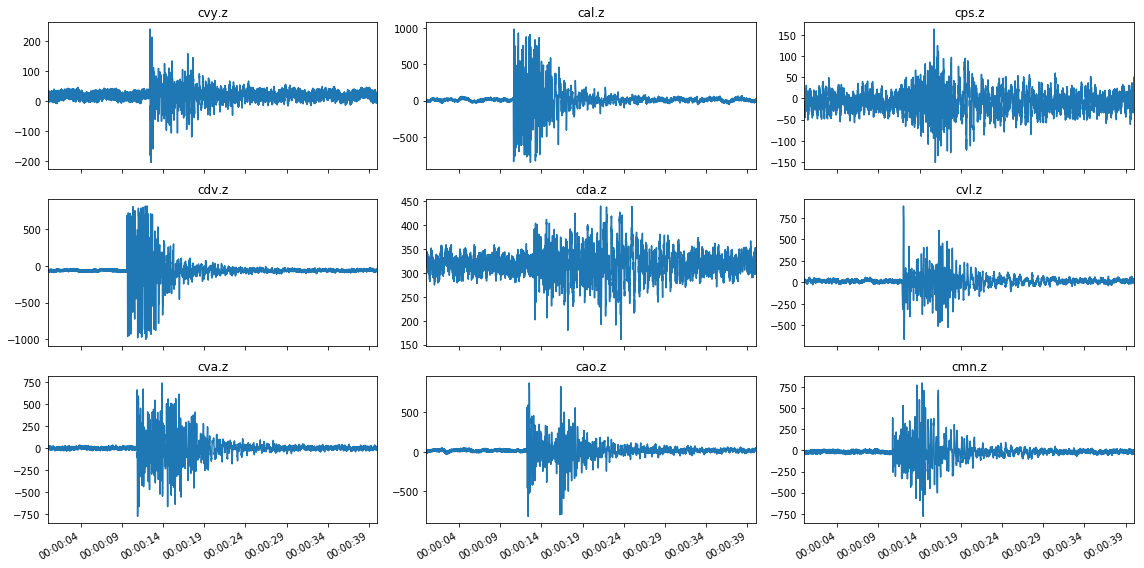

In [2]:
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 8))
i = 0
for n, s in series.items():
    row = i // rows
    col = i % cols
    series[n].plot(ax=axs[row][col], title=n)
    if row != rows - 1:
        axs[row][col].set_xticklabels([])
    i += 1
fig.tight_layout()

## After Butterworth bandpass (5, 10)

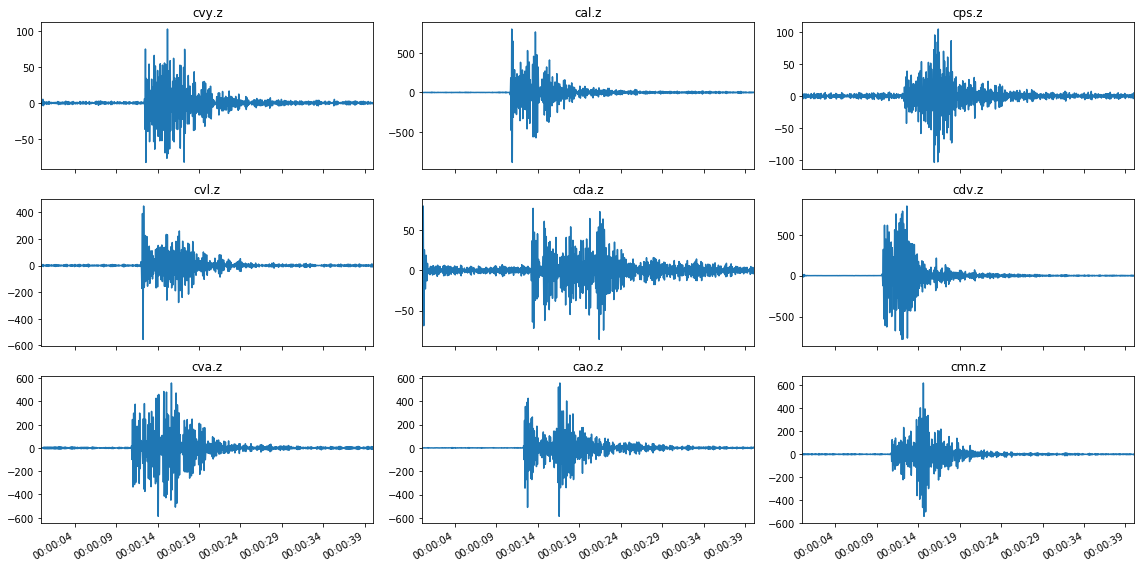

In [3]:
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 8))
i = 0
for n, o in obs.items():
    row = i // rows
    col = i % cols
    o.bandpass(*bandpass)
    det = SaxDetect(o.stream[0].data, o.stats.sampling_rate)
    det.series.plot(ax=axs[row][col], title=n)
    if row != rows - 1:
        axs[row][col].set_xticklabels([])
    i += 1
fig.tight_layout()

## Distribution of whole observation

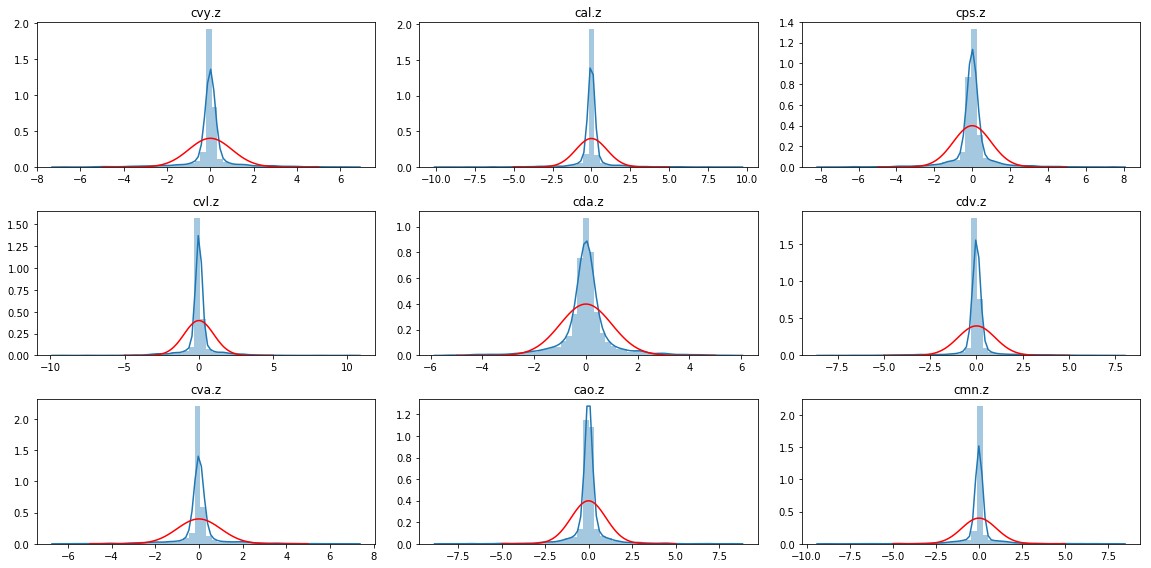

In [4]:
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 8))
i = 0
# normal distribution
x = np.linspace(-5,5,100)
pdf = norm.pdf(x)
for n, o in obs.items():
    row = i // rows
    col = i % cols
    axs[row][col].set_title(n)
    o.bandpass(*bandpass)
    o.normalise()
    sns.distplot(o.stream[0].data, ax=axs[row][col])
    axs[row][col].plot(x, pdf, "r")
    i += 1
fig.tight_layout()

## Distribution of Events (as detected by SAX)

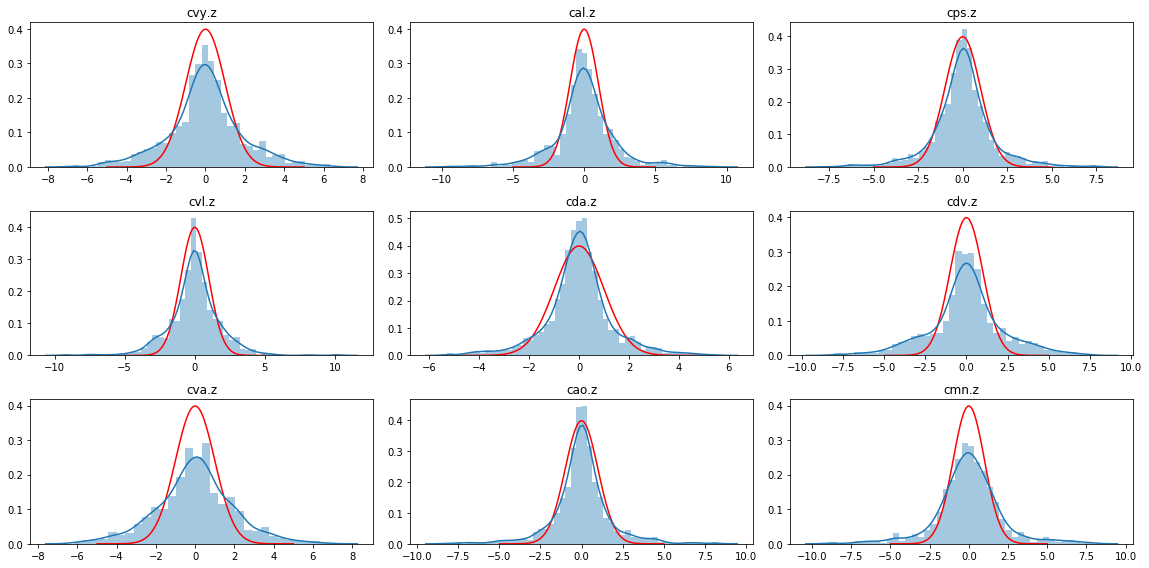

In [5]:
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16, 8))
i = 0

for n, o in obs.items():
    det = SaxDetect(o.stream[0].data, o.stats.sampling_rate)
    evts = det.detect(alphabet, paa_int)
    row = i // rows
    col = i % cols
    axs[row][col].set_title(n)
    axs[row][col].plot(x, pdf, "r")
    o = obs[n]
    o.normalise()
    for evt in evts:
        det = SaxDetect(o.stream[0].data, o.stats.sampling_rate)
        s = det.slice(evt[0], evt[1])
        sns.distplot(s, ax=axs[row][col])
    i += 1
fig.tight_layout()